![title](img/logo.png)
# Biometrics System Concepts
## Assignment 1: Evaluating performance of biometric systems
<b>Name</b>: Marty McFly |
<b>Student-nr</b>: C25 |
<b>Date</b>: June 12, 2015
---

In this assignment we focus on evaluating the performance of any biometric system in a verification and identification setting. 

Before you get started you should be able to properly distinguish verification from identification and know the corresponding validation procedures. If this is not the case for you yet, **review the lecture notes!** We will give a short recap to refresh your memory: 
* **VERIFICATION** (a.k.a. authentication): Authenticating a claimed identity (is this person who he/she claims to be?).

* **IDENTIFICATION**: Associate a particular individual with an identity (who is this unidentified individual?).

This document is structured as follows:

- [I. Reading the data](#I.-Reading-the-data)
- [II. Validation of verification system](#II.-Validation-of-verification-system)
- [III. Validation of identification system](#III.-Validation-of-identification-system)
- [IV. Assignment Instructions](#IV.-Assignment-Instructions)


Code examples will be provided below. You can and are invited to adapt these at your will (different parameter settings, different choices of alogorithmic components). The code examples in this assignment is just sekeleton code,  **adapt where needed! And try to keep things structured!** 

In [1]:
# import the required python packages

import numpy as np
import matplotlib.pyplot as plt
# the following meta-command is required to get plots displayed in notebooks
%matplotlib inline

# package for reading xml files
import xml.etree.ElementTree as ET

import os

# package for data analysis with fast and flexible data structures
import pandas as pd

# package to show a nice graphical progress-bar for lengthy calculations
# docu and installation on https://tqdm.github.io
# if you have difficulties installing this package: 
# - make sure your jupyter lab is up to date
# - https://github.com/tqdm/tqdm/issues/394#issuecomment-384743637
# - consider just leaving it out (just remove the 'tqdm_notebook' in the code)
from tqdm.notebook import tqdm as tqdm_notebook
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, auc
# import local modules for reading and converting BSSR1 fingerprint score data
import src.BSSR1 as BSSR1

<div class="alert alert-block alert-info">
<b>Tip:</b> 
Many operations have already been implemented in <a href="https://docs.scipy.org/doc/numpy/index.html">SciPy</a>, feel free to use them or any other unless explicitely stated not to in the assignment.</div>

## I. Reading the data
In this assignment we focus on the validation of a pre-exising biometric system. We will make use of actual predicted fingerprint similarity scores, from the left and right index fingers. This bypasses all steps of preprocessing, feature extraction and matching and allows us to concentrate on the score evaluation procedures. The scores are the result of comparing an enrolled user's image with the score of the same (genuine scores) or another user (impostor scores). The data (biometrics scores set BSSR1) are made available through the American National Institute of Standards and Technologies [(NIST)](https://www.nist.gov/itl/iad/image-group/nist-biometric-scores-set-bssr1). They are provided as part of your assignment folder in the `data/fing-x-fing` subfolder. 

In this code example we will compare the performance of a biometric system that was based on the right index finger to a biometric system based on the left index finger. These systems are referred to as `ri` and `li` respectively in both code and text.  

### 1.1. Constructing the similarity matrix and reading the genuine and impostor scores
We provide you here with the code to read the scores from the files (normally you can leave this code as-is).

The code consits of 3 steps that are executed for both the `ri` and `li` system: 
1. Converted the scores to a similarity matrix with the genuine scores on the diagonal and the impostor scores on the off-diagonal elements. 
2. Subsample individuals (not needed but reduces calculation times). 
3. Convert the original (subsampled) scores to a linear list of scores with associated labels of genuine or impostor (simplifies use of [scikit-learn](https://scikit-learn.org/stable/index.html))

<div class="alert alert-block alert-info">
<b>Tip:</b> 
For more information about the structure of the data, have a look at the <a href="./data/fing_x_fing/README.html">readme</a>.
</div>


In [2]:
## provide links to the relevant files (you might want to edit these)

# set paths to files containing identity tags of enrollees and users
li_enrollees_id_filepath = './data/fing_x_fing/sets/dos/li/enrollees.xml'
li_users_id_filepath = './data/fing_x_fing/sets/dos/li/users.xml'

ri_enrollees_id_filepath = './data/fing_x_fing/sets/dos/ri/enrollees.xml'
ri_users_id_filepath = './data/fing_x_fing/sets/dos/ri/users.xml'

# set list string for scores files
li_scores_list_str = './data/fing_x_fing/sims/dos/li/V/*.bin'
ri_scores_list_str = './data/fing_x_fing/sims/dos/ri/V/*.bin'

In [3]:
# STEP 1: read BSSR1 scores as a similarity matrix (this might take a while)
(li_fingxfing_dataframe, li_enrollees, li_users, li_column_names) = BSSR1.read_BSSR1_scores_from_file(li_enrollees_id_filepath, li_users_id_filepath, li_scores_list_str)
(ri_fingxfing_dataframe, ri_enrollees, ri_users, ri_column_names) = BSSR1.read_BSSR1_scores_from_file(ri_enrollees_id_filepath, ri_users_id_filepath, ri_scores_list_str)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [4]:
# STEP 2: subsample the scores to a manageable number of individuals
li_similarity_matrix = BSSR1.df2sim_subsample(li_fingxfing_dataframe, column_names = li_column_names, nr_individuals = 1000)
ri_similarity_matrix = BSSR1.df2sim_subsample(ri_fingxfing_dataframe, column_names = ri_column_names, nr_individuals = 1000)

In [5]:
# STEP 3: convert to genuine and impostor scores, the *_genuine_id provides a mask for the genuine scores
li_genuine_id, li_scores = BSSR1.sim2scores(li_similarity_matrix)
ri_genuine_id, ri_scores = BSSR1.sim2scores(ri_similarity_matrix)

<div class="alert alert-block alert-info">
<b>Tip:</b> 
In this assignment we focus only on evaluating biometric systems. It is in your best interest to write your code such that it can easily be reused in the upcoming assignments, where you will have to develop entire biometric system pipelines.</div>

## II. Validation of verification system

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)

The performance of a valitation/authentication scenario can be expressed in a number of ways (see [Jain et al.][1] section 1.4.1.1 for more information). In essence one has a binary classification problem: is it the claimed identity or not? 

We denote our classes as:
<ol start="0">
  <li>Impostor (False),</li>
  <li>Genuine (True).</li>
</ol>

Furthermore, we represent the set of scores as s, the imposter event as $I$ and a genuine event as $G$.

### 1. Evaluation using FMR, FRR, ROC and Precision/Recall curves

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)



#### 1.1 Genuine and impostor score distributions
Given the genuine and impostor scores (from section I), we can plot the imposter $p(s | I)$ and genuine $p(s | G)$ distribution to gain some first insights in the system. The result should look something like this:

<p align="center">
    <img src="img/ScoreDistributions.png" width="250" height="auto"/>
</p>


<div class="alert alert-block alert-success">
<b>Q1: </b> Score distributions
<ul>
  <li>Plot the genuine and impostor score distributions in a single plot.</li>
  <li>Do you need to normalize the distributions? Why (not)?</li>
  <li>Describe qualitatively this combined plot (hint: limit the score range for better understanding)</li>
</ul>  
</div>

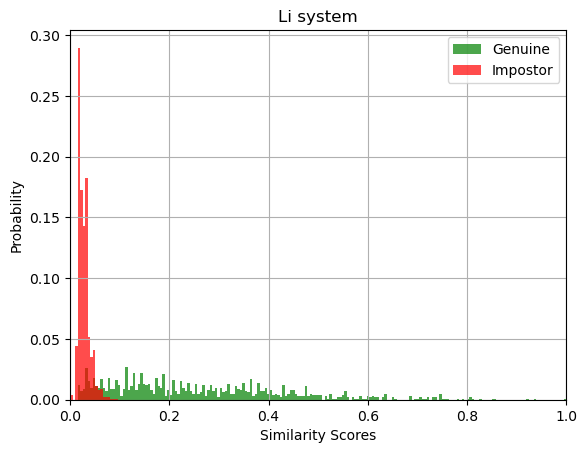

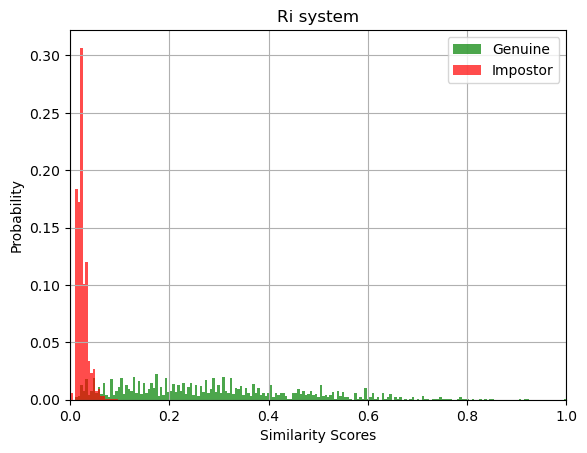

In [6]:
"""Plot the genuine and imposter score distributions."""
#plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('default')
bins = np.linspace(0, 1, 200)

li_genuine_scores = li_scores[li_genuine_id == 1]
li_impostor_scores = li_scores[li_genuine_id == 0]

ri_genuine_scores = ri_scores[ri_genuine_id == 1]
ri_impostor_scores = ri_scores[ri_genuine_id == 0]



#Plot for ri system
weights_genuine = np.ones_like(li_genuine_scores) / len(li_genuine_scores)
plt.hist(li_genuine_scores, weights=weights_genuine, label='Genuine',
         bins=bins, alpha=0.7, color='g')

weights_impostor = np.ones_like(li_impostor_scores) / len(li_impostor_scores)
plt.hist(li_impostor_scores, weights=weights_impostor,label='Impostor',
         bins=bins, alpha=0.7, color='r')
plt.title('Li system')
#plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.xlabel('Similarity Scores')
plt.ylabel('Probability')
plt.grid()
plt.xlim(0,1)
plt.legend()
plt.show()


# Plot for li system
plt.figure()
weights_genuine = np.ones_like(ri_genuine_scores) / len(ri_genuine_scores)
plt.hist(ri_genuine_scores, weights=weights_genuine, label='Genuine',
         bins=bins, alpha=0.7, color='g')

weights_impostor = np.ones_like(ri_impostor_scores) / len(ri_impostor_scores)
plt.hist(ri_impostor_scores, weights=weights_impostor,label='Impostor',
         bins=bins, alpha=0.7, color='r')
plt.title('Ri system')
#plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.xlabel('Similarity Scores')
plt.ylabel('Probability')
plt.grid()
plt.xlim(0,1)
plt.legend()
plt.show()

#### 2. FMR, FRR and Receiver Operating Characteristic (ROC) curve

The 'false accept' and 'false reject' regions in the illustration above are quantified using the False Match/Acceptance Rates (FMR/FAR) and False Non-Match/Rejections Rates (FNMR/FRR). The FMR and FNMR can easily be computed given the previously calculated probability distributions and a threshold value $\eta$. Practically this boils down to a counting problem, having $\mathcal{I}$ the indicator function (return 1 if x is true, else 0) we can compute:
$$
FMR(\eta) = p(s \geq \eta | I) \approx \frac{1}{|I|} \sum_{s \in I} \mathcal{I}(s \geq \eta),
$$
$$
FRR(\eta) = p(s < \eta | G) \approx \frac{1}{|G|} \sum_{s \in G} \mathcal{I}(s < \eta).
$$

We can also compute the Genuine Acceptance Rate (GAR)/True Match Rate (TMR) as:
$$
GAR(\eta) = p(s \geq \eta | G) = 1 - FRR(\eta).
$$

Note that choosing a threshold is always a tradeof between FMR and FNMR. <br>
<img src="img/FAR_FRR.png" width="300" height="auto" align="center"/>

To observe the impact of the threshold value, one often plots a [Receiver Operating Characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve. Usually in these curves the GAR/TMR is plotted against the FMR for different decision threshold values $\eta$. For those familiar with binary classification systems outside of the biometrics literature; the GAR/TMR is often referred to as the True Positive Rate (TPR), sensitivity or recall and FMR is also known as the False Positive Rate (FPR) or the False Accept Rate (FAR). 

<img src="img/ROC.png" width="700" height="auto" align="center"/>

<div class="alert alert-block alert-success">
<b>Q2: </b> ROC Curves
<ul>
    <li>Calculate FPR, TPR from the matching scores.</li>
    <li>Plot FAR and FRR as a function of matching scores.</li>
    <li>Plot the ROC curve. Plot for linear and logarithmic scale if needed. What do you observe?</li>
    <li>Plot the Detection Error Trade-off (DET) curve. How does it compare to ROC?</li>
</ul>  
</div>


<div class="alert alert-block alert-info">
<b>Tip:</b> 
We highly recommend you use the <a href="https://scikit-learn.org/stable/index.html">scikit-learn</a> package, it contains standard and advanced routines for machine learning, including classificaton and validation algorithms.
</div>

In [7]:
"""Calculate FPR, TPR from the matching scores."""
threshold = 0.1
li_impostor_scores_greater_threshold = li_impostor_scores[li_impostor_scores > threshold]
li_genuine_scores_lower_threshold = li_genuine_scores[li_genuine_scores < threshold]

# False Match/Acceptance Rates (FMR/FAR)
FAR = len(li_impostor_scores_greater_threshold) / len(li_impostor_scores)
# False Non-Match/Rejections Rates (FNMR/FRR)
FRR = len(li_genuine_scores_lower_threshold) / len(li_genuine_scores)
GAR = 1 - FRR

TPR = GAR
FPR = FAR
print("FAR:", FAR, "FRR:", FRR, "GAR:", GAR, "TPR:", TPR, "FPR:", FPR)

FAR: 0.0003873873873873874 FRR: 0.216 GAR: 0.784 TPR: 0.784 FPR: 0.0003873873873873874


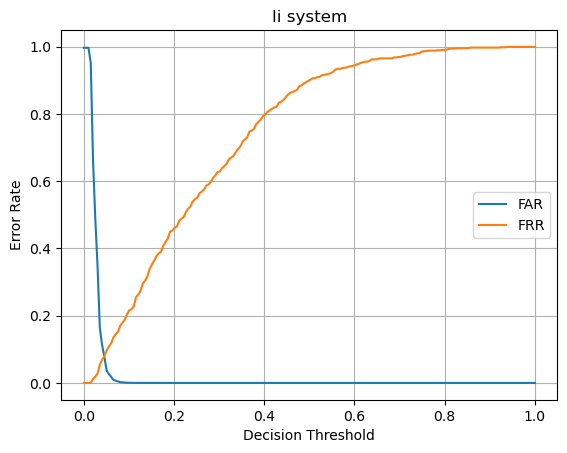

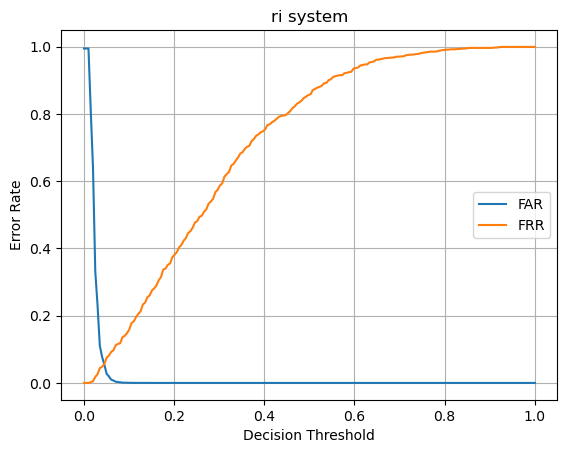

In [8]:
"""Plot FAR and FRR as a function of the decision threshold."""
# FAR <=> FPR
# FRR <=> FNR <=> FN/P <=> 1-TPR

def calculate_FAR(threshold, impostor_scores):
    impostor_scores_greater_threshold = impostor_scores[impostor_scores > threshold]
    FAR = len(impostor_scores_greater_threshold) / len(impostor_scores)
    return FAR

def calculate_FRR(threshold, genuine_scores):
    genuine_scores_lower_threshold = genuine_scores[genuine_scores < threshold]
    FRR = len(genuine_scores_lower_threshold) / len(genuine_scores)
    return FRR

def calculate_TPR(threshold, genuine_scores):
    TPR = 1 - calculate_FRR(threshold, genuine_scores)
    return TPR


li_FAR_array = []
li_FRR_array = []
li_TPR_array = []

ri_FAR_array = []
ri_FRR_array = []
ri_TPR_array = []

for ii in bins:
    li_FAR_array.append(calculate_FAR(ii, li_impostor_scores))
    li_FRR_array.append(calculate_FRR(ii, li_genuine_scores))
    li_TPR_array.append(calculate_TPR(ii, li_genuine_scores))
    ri_FAR_array.append(calculate_FAR(ii, ri_impostor_scores))
    ri_FRR_array.append(calculate_FRR(ii, ri_genuine_scores))
    ri_TPR_array.append(calculate_TPR(ii, ri_genuine_scores))
    
plt.plot(bins, li_FAR_array,label='FAR')
plt.plot(bins, li_FRR_array, label='FRR')
plt.title('li system')
plt.legend()
plt.grid()
plt.xlabel('Decision Threshold')
plt.ylabel('Error Rate')
#plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.show()

plt.figure()
plt.plot(bins, ri_FAR_array,label='FAR')
plt.plot(bins, ri_FRR_array, label='FRR')
plt.title('ri system')
plt.legend()
plt.grid()
plt.xlabel('Decision Threshold')
plt.ylabel('Error Rate')
#plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.show()
    

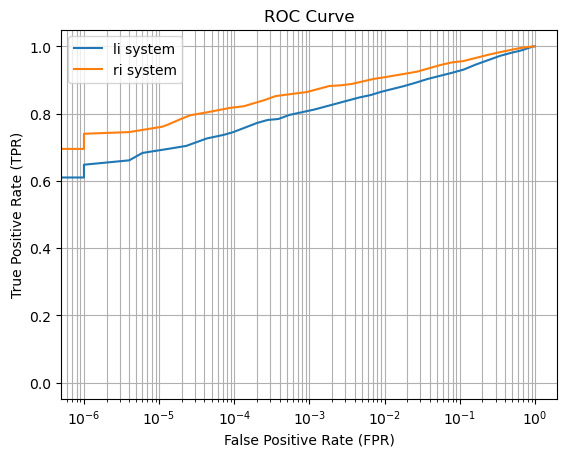

In [9]:
"""plot the ROC curve (TPR against the FPR for different threshold values)"""
li_FPR_array = li_FAR_array
ri_FPR_array = ri_FAR_array

plt.plot(li_FPR_array, li_TPR_array, label='li system')
plt.plot(ri_FPR_array, ri_TPR_array, label='ri system')
plt.xscale('log')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, which='both')
plt.show()



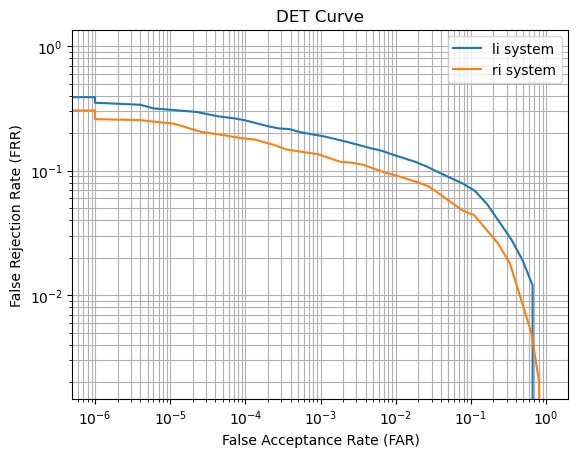

In [10]:
"""plot the DET curve (FRR (=1-tpr) against the FAR for different threshold values)"""

# FAR <=> FPR
# FRR <=> FNR <=> FN/P <=> 1-TPR
plt.figure()
plt.style.use("default")
plt.loglog(li_FAR_array, li_FRR_array, label='li system')
plt.loglog(ri_FAR_array, ri_FRR_array, label='ri system')
plt.xlabel('False Acceptance Rate (FAR)')
plt.ylabel('False Rejection Rate (FRR)')
plt.title('DET Curve')
plt.legend()
plt.grid(True, which='both')
plt.show()

#### 3. F1 and accuracy as metrics

While biometric systems are, traditionally, evaluated using FMR and FRR and ROC/DET curves, we can also have a look at traditional [classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) such as classification accuracy (or error) and F1 measure. 

<div class="alert alert-block alert-success">
<b>Q3: </b> Classification Metrics
<ul>
    <li>Plot F1 and accuracy as a function of the decision thresholds on the similarity score.</li>
    <li>Calculate the threshold and accuracy for which F1 is maximal. Is it an interesting operating point?</li>
    <li>Do the same for the classification error (accuracy). Is there a difference?</li>
    <li>Is accuracy a good performance metric in this case?</li>
</ul>  
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> 
We highly recommend you use the <a href="https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics">scikit-learn classification metrics</a> to assist.
</div>


li system -> Threshold for which F1 is maximal: 0.12244897959183673
li system -> Max F1 score: 0.8208027133973996
ri system -> Threshold for which F1 is maximal: 0.12244897959183673
ri system -> Max F1 score: 0.870575221238938


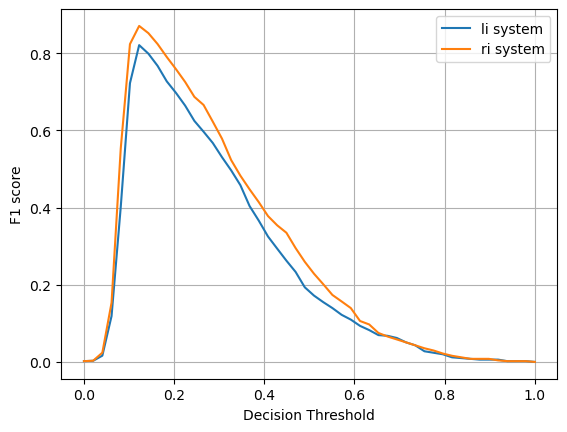

In [11]:
"""Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
# Hint: evaluating for ± 50 threshold values should suffice
threshold_values = np.linspace(0, 1, 50)

li_f1_score_array = []
ri_f1_score_array = []
for threshold_value in threshold_values: 
    li_predicted_scores = np.array(li_scores > threshold_value).astype('int')
    li_f1_score = f1_score(li_genuine_id, li_predicted_scores)
    li_f1_score_array.append(li_f1_score)

    ri_predicted_scores = np.array(ri_scores > threshold_value).astype('int')
    ri_f1_score = f1_score(ri_genuine_id, ri_predicted_scores)
    ri_f1_score_array.append(ri_f1_score)
    
plt.plot(threshold_values, li_f1_score_array, label='li system')
plt.plot(threshold_values, ri_f1_score_array, label='ri system')
plt.xlabel('Decision Threshold')

plt.ylabel('F1 score')
plt.grid()
plt.legend()
#plt.title('Plot of F1 scores as a function of the decision thresholds on the similarity score')
idx_max_li = np.argmax(li_f1_score_array)
threshold_value_maximize_f1_li = threshold_values[idx_max_li]
print("li system -> Threshold for which F1 is maximal:",threshold_value_maximize_f1_li)
print("li system -> Max F1 score:", li_f1_score_array[idx_max_li])


idx_max_ri = np.argmax(ri_f1_score_array)
threshold_value_maximize_f1_ri = threshold_values[idx_max_ri]
print("ri system -> Threshold for which F1 is maximal:",threshold_value_maximize_f1_ri)
print("ri system -> Max F1 score:", ri_f1_score_array[idx_max_ri])

In [12]:
"""Calculate the threshold for which F1 is maximal."""
#Has been done in the cell above.


'Calculate the threshold for which F1 is maximal.'

li system -> Threshold for which accuracy is maximal: 0.12244897959183673
li system -> Max accuracy score: 0.999683
ri system -> Threshold for which accuracy is maximal: 0.12244897959183673
ri system -> Max accuracy score: 0.999766


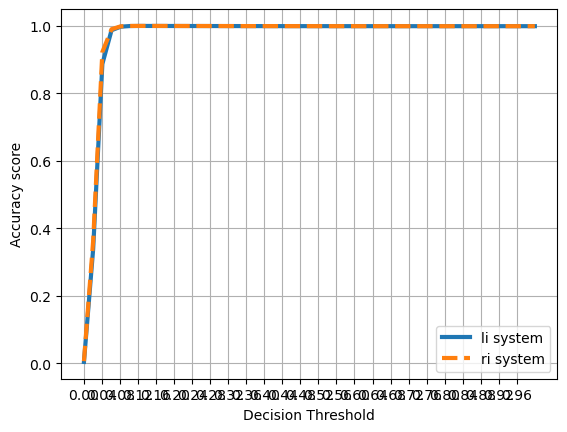

In [13]:
"""Do the same for the classification error (or accuracy)"""
#plt.rcParams['figure.figsize'] = [12, 8]
li_accuracy_score_array = []
ri_accuracy_score_array = []
for threshold_value in threshold_values: 
    li_predicted_scores = np.array(li_scores > threshold_value).astype('int')
    li_accuracy_score = accuracy_score(li_genuine_id, li_predicted_scores)
    li_accuracy_score_array.append(li_accuracy_score)

    
    ri_predicted_scores = np.array(ri_scores > threshold_value).astype('int')
    ri_accuracy_score = accuracy_score(ri_genuine_id, ri_predicted_scores)
    ri_accuracy_score_array.append(ri_accuracy_score)
    
plt.plot(threshold_values, li_accuracy_score_array, label='li system', linestyle='-', linewidth=3)
plt.plot(threshold_values, ri_accuracy_score_array, label='ri system', linestyle='--', linewidth=3)
plt.xlabel('Decision Threshold')
plt.ylabel('Accuracy score')

plt.xticks(np.arange(0, 1, step=0.04))
plt.grid()
plt.legend()

idx_max_li = np.argmax(li_accuracy_score_array)
threshold_value_maximize_accuracy_li = threshold_values[idx_max_li]
print("li system -> Threshold for which accuracy is maximal:",threshold_value_maximize_accuracy_li)
print("li system -> Max accuracy score:", li_accuracy_score_array[idx_max_li])

idx_max_ri = np.argmax(ri_accuracy_score_array)
threshold_value_maximize_accuracy_ri = threshold_values[idx_max_ri]
print("ri system -> Threshold for which accuracy is maximal:",threshold_value_maximize_accuracy_ri)
print("ri system -> Max accuracy score:", ri_accuracy_score_array[idx_max_ri])


#### 4. AUC and EER as summary measures

The overall performance (over all threshold settings) is typically expressed through:

* The Area Under the Curve (AUC) (with TPR((y-axis) vs FPR (x-axis))

<img src="img/AUC.png" width="250" height="auto"/>

The AUC can be used to compare different systems. The larger this number, the better.
However, since it is a summary measure, always inspect the full ROC curve to make decisions about performance given operating conditions (in wich FRR, FAR regime to work e.g.).

* The Equal Error Rate (EER), which is the point on the ROC-curve where FAR(FMR) equals FRR (1-TAR). A lower EER value indicates better performance. 

<img src="img/EER.png" width="300" height="300"/>

<div class="alert alert-block alert-success">
<b>Q4: </b> AUC, EER and alternatives
<ul>
    <li>Calculate ROC AUC. Is this a good metric? What does it reveal about the system? </li>
    <li>Calculate (by approximation) the EER and plot it on the FAR-FRR curve. Is this a good peration point?</li>
    <li>Calculate the decision threshold for which the sum of FRR and FAR is minimal. Is this point similar to the total classification error?</li> 
    <li>Can you suggest other strategies that give you an "optimal" performance? Calculate and discuss their (de)merits.</li>
</ul>  
</div>


In [14]:
"""Calculate the ROC AUC."""
li_roc_auc_score = roc_auc_score(li_genuine_id, li_scores)
ri_roc_auc_score = roc_auc_score(ri_genuine_id, ri_scores)
print('li system ROC AUC score:', li_roc_auc_score)
print('rI system ROC AUC score:', ri_roc_auc_score)

li system ROC AUC score: 0.9712470650650651
rI system ROC AUC score: 0.9826611286286288


Li intersection point [0.0787636] [0.0787636]
Ri intersection point [0.05558848] [0.05558848]


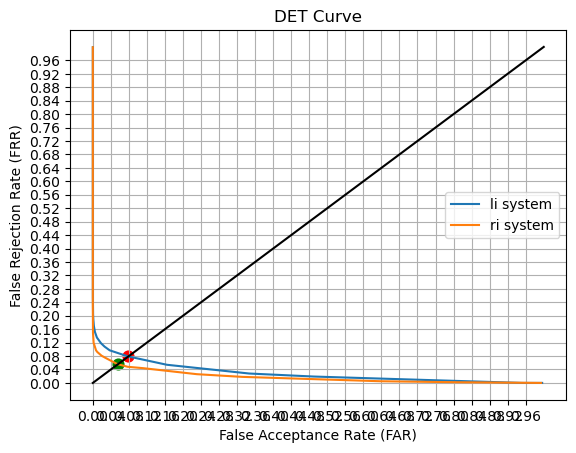

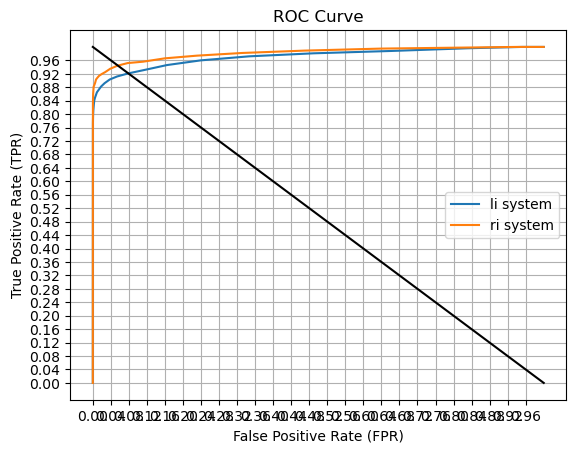

In [15]:
"""Calculate (by approximation) the EER and plot it on the FAR-FRR curve."""
# hints:
#  - avoid using a library that directly computes the EER for this assignment
#plt.rcParams['figure.figsize'] = [12, 8]
#li_eer = brentq(lambda x : 1. - x - interp1d(li_fpr, li_tpr)(x), 0., 1.)
#li_thresh = interp1d(li_fpr, li_thresholds)(li_eer)
#print("EER for li system:", li_eer,"Threshold:" ,li_thresh)

#ri_eer = brentq(lambda x : 1. - x - interp1d(ri_fpr, ri_tpr)(x), 0., 1.)
#ri_thresh = interp1d(ri_fpr, ri_thresholds)(ri_eer)
#print("EER for ri system:", ri_eer, "Threshold:",ri_thresh)

#plt.scatter(li_thresh, li_eer, marker='x')
#plt.scatter(ri_thresh, ri_eer, marker='x')
#plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(li_FAR_array, li_FRR_array, label='li system')
plt.plot(ri_FAR_array, ri_FRR_array, label='ri system')
plt.plot(np.linspace(0,1,200),np.linspace(0,1,200), color='black')

!pip install intersect
from intersect import intersection
x_li, y_li = intersection(np.linspace(0,1,200),np.linspace(0,1,200), li_FAR_array, li_FRR_array)
print("Li intersection point",x_li, y_li)
plt.scatter(x_li, y_li, c='r', s=60)
x_ri, y_ri = intersection(np.linspace(0,1,200),np.linspace(0,1,200), ri_FAR_array, ri_FRR_array)
print("Ri intersection point",x_ri, y_ri)
plt.scatter(x_ri, y_ri, c='g', s=60)
plt.xlabel('False Acceptance Rate (FAR)')
plt.ylabel('False Rejection Rate (FRR)')
plt.title('DET Curve')
plt.xticks(np.arange(0, 1, step=0.04))
plt.yticks(np.arange(0, 1, step=0.04))
plt.legend()
plt.grid()

plt.figure()
li_fpr, li_tpr, li_thresholds = roc_curve(li_genuine_id, li_scores, pos_label=1)
plt.plot(li_fpr, li_tpr, label='li system')
ri_fpr, ri_tpr, ri_thresholds = roc_curve(ri_genuine_id, ri_scores, pos_label=1)
plt.plot(ri_fpr,ri_tpr, label='ri system')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.plot(np.linspace(0,1,200),np.linspace(1,0,200), color='black')
plt.xticks(np.arange(0, 1, step=0.04))
plt.yticks(np.arange(0, 1, step=0.04))
plt.legend()
plt.grid()


In [16]:
print('Li threshold for EER: ',li_FAR_array[9], li_FRR_array[9], li_thresholds[9])

Li threshold for EER:  0.07793493493493493 0.079 0.7099236641221374


li system-> Decision threshold for which the sum of FRR and FAR is minimal: 0.05527638190954774
li system-> Minimal value of the sum of FRR and FAR 0.13406206206206206
ri system-> Decision threshold for which the sum of FRR and FAR is minimal: 0.05527638190954774
ri system-> Minimal value of the sum of FRR and FAR 0.10040640640640641


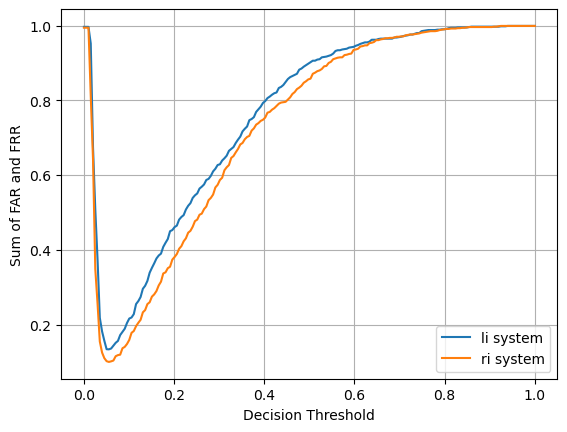

In [17]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""
# hint: same as above

li_FAR_FRR_array = np.add(li_FAR_array, li_FRR_array)
li_idx_min = np.argmin(li_FAR_FRR_array)
print('li system-> Decision threshold for which the sum of FRR and FAR is minimal:',bins[li_idx_min])
print('li system-> Minimal value of the sum of FRR and FAR',li_FAR_FRR_array[li_idx_min])
plt.plot(bins, li_FAR_FRR_array, label='li system')

ri_FAR_FRR_array = np.add(ri_FAR_array, ri_FRR_array)
ri_idx_min = np.argmin(ri_FAR_FRR_array)
print('ri system-> Decision threshold for which the sum of FRR and FAR is minimal:', bins[ri_idx_min])
print('ri system-> Minimal value of the sum of FRR and FAR', ri_FAR_FRR_array[ri_idx_min])
plt.plot(bins, ri_FAR_FRR_array, label='ri system')

plt.xlabel('Decision Threshold')
plt.ylabel('Sum of FAR and FRR')
plt.legend()
plt.grid()


#### 5. Evaluation using Precision and Recall

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)
[3]: <https://en.wikipedia.org/w/index.php?title=Information_retrieval&oldid=793358396#Average_precision> (Average precision)

In a general binary classification setting, one also often presents Precision-Recall curves. PR-curves are sometimes summarized using the [average precision scores][3]. How and when to use ROC or PRC is discussed [here][2]. A more general discussion of these measures is provided [here](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c).  

Scikit-Learn provides routines for calculating these curves and numbers as demonstrated in the code below from this [link][2], it also provides an implementation of the [average precision scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score).


<div class="alert alert-block alert-success">
<b>Q5: </b> Precision-Recall curves and related summary measures
<ul>
    <li>Calculate and plot the Precision-Recall curve for this system. What does it reveal about the performance of the system?</li>
    <li>Calculate the Area Under the PR-curve. Discuss.</li>
    <li>Calculate the average precision scores. Discuss its value.</li> 
</ul>  
</div>


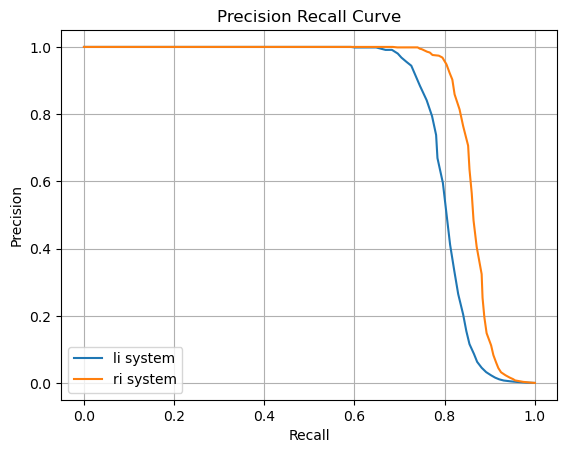

In [18]:
"""Calculate and plot the Precision-Recall curve for this system"""
from sklearn.metrics import precision_recall_curve

li_precision, li_recall, li_thresholds_pr = precision_recall_curve(li_genuine_id, li_scores)
ri_precision, ri_recall, ri_thresholds_pr = precision_recall_curve(ri_genuine_id, ri_scores)

plt.plot(li_recall, li_precision, label='li system')
plt.plot(ri_recall, ri_precision, label= 'ri system')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.grid()
plt.legend()

In [19]:
"""Calculate the Area Under the PR-curve."""

li_auc = auc(li_recall, li_precision)
ri_auc = auc(ri_recall, ri_precision)
print('The Area Under the PR-curve for li system',(li_auc))
print('The Area Under the PR-curve for ri system,',(ri_auc))


The Area Under the PR-curve for li system 0.8034780801507487
The Area Under the PR-curve for ri system, 0.8627573994779721


In [20]:
"""Calculate the average precision scores"""
li_avg_precision_scores = np.average(li_precision)
ri_avg_precision_scores = np.average(ri_precision)

print('li system-> Average precision scores:', li_avg_precision_scores)
print('ri system-> Average precision scores:', ri_avg_precision_scores)

li system-> Average precision scores: 0.8865123884028598
ri system-> Average precision scores: 0.8977247359413186


## III. Validation of identification system 

### Evaluation using CMC curves
In an identification scenario one has a 1-to-many or multi-class classification problem. The performance of such a system is typically measured by the Cumulative Match Characteristic (CMC) curve. This curve plots the experimental probability that a correct identification is returned within the top-x (x=1, ..., N) ranked matching scores. 

<img src="img/CMC.jpg" width="500" height="auto"/>

[Bolle et al.](https://ieeexplore.ieee.org/document/1544394) show that:
> the CMC is also related to the FAR and FRR of a 1:1 matcher, i.e., the matcher that is used to rank the candidates by sorting the scores. This has as a consequence that when a 1:1 matcher is used for identification, that is, for sorting match scores from high to low, the CMC does not offer any additional information beyond the FAR and FRR curves. The CMC is just another way of displaying the data and can be computed from the FAR and FRR.

This paper is not mandatory but those interested can have a look at it.

CMC curves can easily be generated once you have the ranked matching scores for every test sample. In our example we can easily calculate it from the similarity matrix (note that in this very particular case we have only one genuine pair per test sample). 



<div class="alert alert-block alert-success">
<b>Q6: </b> CMC curves
<ul>
    <li>Calculate the Cumulative Matching Characteristic curve (implement this yourself)</li>
    <li>Compute the Rank-1 Recognition Rate.</li>
</ul>  
</div>


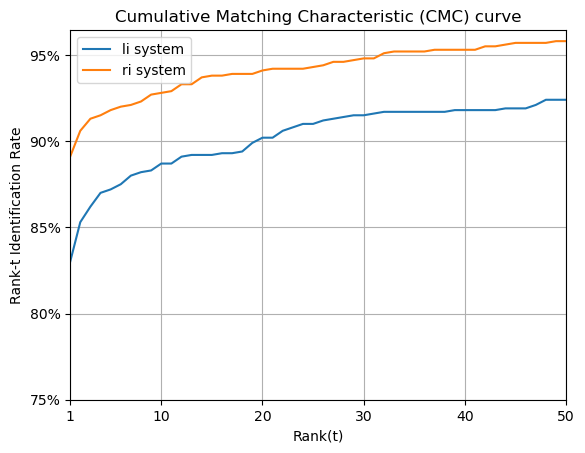

In [21]:
"""Calculate the Cumulative Matching Characteristic curve."""
# Hint: don't use a library

li_rank_identification_rate_array = []
ri_rank_identification_rate_array = []

for ii in range(1, 51):
    li_similarity_matrix_copy = li_similarity_matrix.copy()
    li_similarity_matrix_copy_largest = li_similarity_matrix_copy.apply(pd.Series.nlargest, axis=0, n=ii).reindex(li_similarity_matrix_copy.columns)
    li_rank_identification_rate = sum(~np.isnan(np.diagonal(li_similarity_matrix_copy_largest.values))) / li_similarity_matrix_copy_largest.shape[0]
    li_rank_identification_rate_array.append(li_rank_identification_rate)

    ri_similarity_matrix_copy = ri_similarity_matrix.copy()
    ri_similarity_matrix_copy_largest = ri_similarity_matrix_copy.apply(pd.Series.nlargest, axis=0, n=ii).reindex(ri_similarity_matrix_copy.columns)
    ri_rank_identification_rate = sum(~np.isnan(np.diagonal(ri_similarity_matrix_copy_largest.values))) / ri_similarity_matrix_copy_largest.shape[0]
    ri_rank_identification_rate_array.append(ri_rank_identification_rate)

plt.plot(np.arange(1, 51), li_rank_identification_rate_array, label='li system')
plt.plot(np.arange(1, 51), ri_rank_identification_rate_array, label='ri system')
plt.title('Cumulative Matching Characteristic (CMC) curve')
plt.xlabel('Rank(t)')
plt.ylabel('Rank-t Identification Rate')
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xlim(1, 50)
plt.yticks(np.arange(0.75, 1, 0.05))
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid()
plt.show()

In [22]:
"""compute the Rank-1 Recognition Rate."""
print('li system-> Rank-1 Recognition Rate:', li_rank_identification_rate_array[0])
print('ri system-> Rank-1 Recognition Rate:', ri_rank_identification_rate_array[0])

li system-> Rank-1 Recognition Rate: 0.83
ri system-> Rank-1 Recognition Rate: 0.891


<div class="alert alert-block alert-success">
<b>Q7: </b> Evaluate different biometric systems
<ul>
    <li>Use above evaluation techniques to compare the biometric system based on the left index to the right index </li>
    <li>Do you see any differences in any of the curves or measures?</li>
</ul>  
</div>

## IV. Assignment Instructions
For this assignment you have to submit a report (.pdf) and the implementation of this notebook (.ipynb) to toledo. The report should be between 3-8 pages (more pages $\nRightarrow$ higher score) and should be structured around the posed questions (Q1,...). The text should demonstrate your understanding of the material and, depending on the question, clearly introduce the context, technique, your expectation and interpretation of the results. Do not limit yourselves to just answering the questions. Feel free to add figures and, if needed, some *small* code snippet to clarify your position. **The report should be self contained, the notebook functions as supplementary material only!**

*Note: Make sure you include all the files required to run the notebooks on submission.* <br>
*Note 2: The deadline for this project is: 09/03 23:59 CET.* 